In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Convert image to unsigned integer
def convert_to_uint8(image):
    """
    Convert the image to uint8.
    """
    image = image * 255.0  # Assuming the image is in the range [0, 1]
    image = tf.cast(image, tf.uint8)
    return image


# Define image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values from 0-255 to 0-1
# preprocessing_function=convert_to_uint8,  # Apply the custom preprocessing function
    shear_range=0.2,      # Randomly apply shearing transformation
    zoom_range=0.2,       # Randomly zoom in images
    horizontal_flip=True, # Randomly flip images horizontally
    validation_split=0.2  # Split the data into training and validation sets
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\Boluwatife\Steganalysis\dataset_original',  # Path to the dataset directory
    target_size=(256, 256),   # Resize images to 256x256 pixels
    batch_size=32,            # Number of images to yield per batch
    class_mode='binary',      # Binary labels (use 'categorical' for multi-class)
    subset='training'         # Use the training subset
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
     r'C:\Users\Boluwatife\Steganalysis\dataset',  # Use the same directory as above
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation'       # Use the validation subset
)

Found 6396 images belonging to 2 classes.
Found 1598 images belonging to 2 classes.


Found 7995 images belonging to 2 classes.


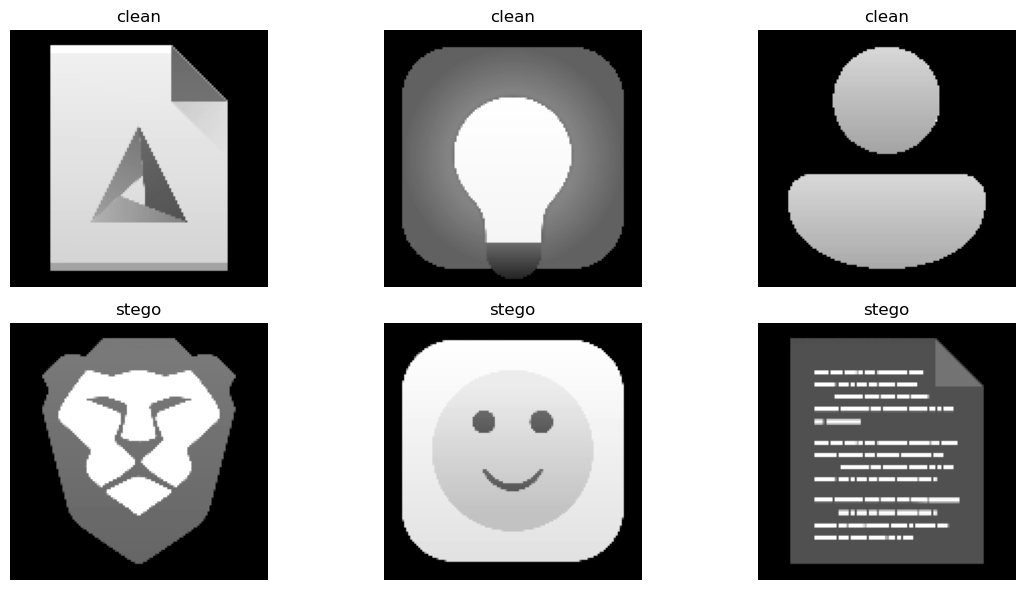

In [8]:
#Display some images

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def display_samples(data_dir, target_size=(128, 128), batch_size=32, num_samples=3):
    # Create an ImageDataGenerator to load images
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # or 'categorical' based on your labels
        color_mode='grayscale',  # Assuming grayscale images
        shuffle=True
    )
    
    # Create a figure to display the images
    plt.figure(figsize=(12, 6))
    
    class_labels = {v: k for k, v in generator.class_indices.items()}
    
    for class_idx, class_name in class_labels.items():
        # Get images and labels
        X_batch, y_batch = next(generator)
        
        # Find the indices of the samples from this class
        class_indices = [i for i in range(len(y_batch)) if y_batch[i] == class_idx]
        
        # Display samples
        for i in range(min(num_samples, len(class_indices))):
            plt.subplot(2, num_samples, class_idx * num_samples + i + 1)
            plt.imshow(X_batch[class_indices[i]].squeeze(), cmap='gray')
            plt.title(f"{class_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Directory path
data_dir = r'C:\Users\Boluwatife\Steganalysis\dataset_original'  # Replace with your dataset path

# Display samples
display_samples(data_dir)


In [47]:
# Load Images Using ImageDataGenerator
def load_images(data_dir, target_size=(128, 128), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # 'binary' or 'categorical' based on your dataset
        color_mode='grayscale',  # Using grayscale for GLCM
        shuffle=True
    )
    return generator

# Apply GLCM to Extract Features
def apply_glcm(image):
    glcm = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    asm = graycoprops(glcm, 'ASM').flatten()
    return np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation, asm])

# Apply SMOTE
def apply_smote(X, y):
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Save Processed Images
def save_image(image, save_dir, image_name):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, image_name)
    cv2.imwrite(save_path, image * 255)  # Re-multiply by 255 if originally normalized

# Example Workflow
def process_images(data_dir, output_dir, batch_size=32, target_size=(128, 128)):
    generator = load_images(data_dir, target_size=target_size, batch_size=batch_size)
    
    all_glcm_features = []
    all_labels = []
    
    # Get class labels from the generator
    class_labels = {v: k for k, v in generator.class_indices.items()}

    for i, (X_batch, y_batch) in enumerate(generator):
        if i >= len(generator):  # Avoid infinite loop
            break
        
        for j in range(X_batch.shape[0]):
            image = X_batch[j].squeeze()  # Grayscale image
            label = y_batch[j]
            
            # Apply GLCM feature extraction
            glcm_features = apply_glcm(image.astype(np.uint8))
            all_glcm_features.append(glcm_features)
            all_labels.append(label)
    
    # Convert to NumPy arrays for SMOTE
    X_glcm = np.array(all_glcm_features)
    y_glcm = np.array(all_labels)
    
    # Apply SMOTE to balance the dataset
    X_resampled, y_resampled = apply_smote(X_glcm, y_glcm)
    
    # Reshape GLCM features back to image format and save the processed images
    for i, (glcm_feature, label) in enumerate(zip(X_resampled, y_resampled)):
        reshaped_image = glcm_feature.reshape((4, 6))  # Adjusted shape to match the size of 24
        image_name = f"image_{i}.png"
        class_dir = class_labels[label]
        save_image(reshaped_image, os.path.join(output_dir, class_dir), image_name)


# Directory paths
data_dir = r'C:\Users\Boluwatife\Steganalysis\dataset_original'  # Replace with your dataset path
output_dir = r'C:\Users\Boluwatife\Steganalysis\glcm_smote_dataset'  # Where processed images will be saved

# Process the images
process_images(data_dir, output_dir)


Found 7995 images belonging to 2 classes.


In [59]:
def split_dataset(data_dir, output_dir, val_split=0.2):
    """
    Splits dataset into training and validation directories.

    Parameters:
    - data_dir: Directory containing the original dataset.
    - output_dir: Directory where the train and val subdirectories will be created.
    - val_split: Fraction of images to be used for validation.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get the class directories
    class_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    for class_dir in class_dirs:
        class_name = os.path.basename(class_dir)
        # Create train and val directories
        train_dir = os.path.join(output_dir, 'train', class_name)
        val_dir = os.path.join(output_dir, 'val', class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        
        # List all images in the class directory
        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        
        # Split images into train and val sets
        train_files, val_files = train_test_split(images, test_size=val_split, random_state=42)
        
        # Move files to corresponding directories
        for file in train_files:
            shutil.copy(file, train_dir)
        for file in val_files:
            shutil.copy(file, val_dir)

    print(f"Dataset split into 'train' and 'val' directories under {output_dir}")

# Directory paths
data_dir = r'C:\Users\Boluwatife\Steganalysis\glcm_smote_dataset'  # Replace with your dataset path
output_dir = r'C:\Users\Boluwatife\Steganalysis\split_glcm_smote_dataset'  # Directory to store the train and val directories

# Split the dataset
split_dataset(data_dir, output_dir)


Dataset split into 'train' and 'val' directories under C:\Users\Boluwatife\Steganalysis\splitDataset


In [3]:
# Directory paths
train_dir = r'C:\Users\Boluwatife\Steganalysis\split_glcm_smote_dataset\train'  # training dataset path
val_dir = r'C:\Users\Boluwatife\Steganalysis\split_glcm_smote_dataset\val'  # validation dataset path


In [5]:
# Create data generators

def create_generator(data_dir, target_size=(128, 128), batch_size=32, mode='binary'):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=mode,
        color_mode='grayscale',  # Or 'rgb' if using color images
        shuffle=True
    )
    
train_generator = create_generator(train_dir)
val_generator = create_generator(val_dir)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [6]:
def build_srnet(input_shape=(256, 256, 1)):
    model = models.Sequential()

    # Add an explicit Input layer
    model.add(layers.Input(shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.GlobalAveragePooling2D())

    # Dense Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer (Binary classification for steganalysis)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Example usage
input_shape = (256, 256, 1)  # Assuming grayscale images of size 256x256
model = build_srnet(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,719,553 (6.56 MB)

 Trainable params: 1,716,865 (6.55 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [8]:
# Define image size and batch size
img_height, img_width = 256, 256
batch_size = 32  # Make sure to define batch_size

In [7]:


# Train the model using fit_generator
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)


Epoch 1/30


C:\Users\Boluwatife\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.5139 - loss: 0.9472 - val_accuracy: 0.5000 - val_loss: 1.0670
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30


C:\Users\Boluwatife\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.5258 - loss: 0.7985 - val_accuracy: 0.5000 - val_loss: 0.7353
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.5320 - loss: 0.7348 - val_accuracy: 0.5000 - val_loss: 0.7872
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.5175 - loss: 0.7175 - val_accuracy: 0.5263 - val_loss: 0.7349
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.5201 - loss: 0.7047 - val_accuracy: 0.5181 - val_loss: 0.6861
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.5211 - loss: 0.6885 - val_accuracy: 0.5213

In [13]:
# Load your saved Keras model
model = load_model(r'C:\Users\Boluwatife\Steganalysis\glcm_smote_model.keras')

In [18]:
# Evaluate the model

# Assuming you have already set up the ImageDataGenerator for the test data
# Example for test generator setup

# Load the test data with the image generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    r'C:\Users\Boluwatife\Steganalysis\test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',  # or 'binary' if it's binary classification
    shuffle=False  # Ensure that shuffling is disabled for proper evaluation
)

Found 4000 images belonging to 2 classes.


In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get model predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluate metrics
accuracy = np.sum(y_true == y_pred.flatten()) / len(y_true)

# Print classification report and confusion matrix
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred.flatten(), target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred.flatten()))


C:\Users\Boluwatife\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

   cleanTest       0.50      1.00      0.67      2000
   stegoTest       0.00      0.00      0.00      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000

Confusion Matrix:
[[2000    0]
 [2000    0]]


C:\Users\Boluwatife\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Boluwatife\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Boluwatife\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Save the model
model.save('glcm_smote_model2.keras')